In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt
import plotly.offline as pyoff
from plotly.graph_objs import *
from plotly import tools

In [2]:
pyoff.init_notebook_mode(connected=True)

# EEG Channels Animation

In [3]:
alcoholic_data = pd.read_feather('data/alcoholics')
control_data = pd.read_feather('data/controls')
with open('data/channel_map.txt', 'r') as f:
    lines = [line.strip().split()[2:] for line in f.readlines()]
    channel_map_dict = {line[0].upper(): [float(elem) for elem in line[1:]] for line in lines}

In [4]:
grouped_alcoholic_data = alcoholic_data.groupby(['channel', 'timepoint'])['signal'].mean().reset_index()
grouped_control_data = control_data.groupby(['channel', 'timepoint'])['signal'].mean().reset_index()
grouped_alcoholic_data.shape, grouped_control_data.shape

((15616, 3), (15616, 3))

In [155]:
def animate_plotly(alcoholic_data, control_data, channel_map_dict):
    
    def get_vals(df, tp, typ):
        now = df[df['timepoint'] == tp]
        coords = np.array([channel_map_dict[chan] for chan in now['channel']])
        colors = [sig for sig in now['signal']]
        return coords, colors, now['channel']
    
    def get_frame(tp):
        coords_alc, colors_alc, chans_alc = get_vals(alcoholic_data, tp, 'alc')
        trace_alc = Scatter(
            x = coords_alc[:,0],
            y = coords_alc[:,1],
            hovertext = chans_alc,
            mode='markers',
            marker=dict(
                size='16',
                color = colors_alc, #set color equal to a variable
                cmin = cmin,
                cmax = cmax,
                colorscale = 'BlueRed',
                showscale=True
            )
        )
        
        coords_ctrl, colors_ctrl, chans_ctrl = get_vals(control_data, tp, 'ctrl')
        trace_ctrl =  Scatter(
            x = coords_ctrl[:,0],
            y = coords_ctrl[:,1],
            hovertext = chans_ctrl,
            mode='markers',
            marker=dict(
                size='16',
                color = colors_ctrl, #set color equal to a variable
                cmin = cmin,
                cmax = cmax,
                colorscale = 'BlueRed',
                showscale=False
            )
        )
        
        layout = Layout(
            title = 'Timepoint %d' % tp,
            showlegend=False,
            xaxis=dict(
            domain=[0, 0.45]
            ),
            xaxis2=dict(
                domain=[0.55, 9]
            ),
            yaxis2=dict(
                anchor='x2'
            ),
            updatemenus = [
                {
                    'buttons': [
                        {
                            'args': [None, {'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                            'label': 'Play',
                            'method': 'animate'
                        },
                        {
                            'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                            'transition': {'duration': 0}}],
                            'label': 'Pause',
                            'method': 'animate'
                        }
                    ],
                    'direction': 'left',
                    'pad': {'r': 10, 't': 87},
                    'showactive': False,
                    'type': 'buttons',
                    'x': 0.1,
                    'xanchor': 'right',
                    'y': 0,
                    'yanchor': 'top'
                }
            ]
        )
        
        data = [trace_alc, trace_ctrl]
        return data, layout

    
    tp_max = 256
    all_tps = range(tp_max)
    cmin = np.min(np.vstack([alcoholic_data['signal'], control_data['signal']]))
    cmax = np.max(np.vstack([alcoholic_data['signal'], control_data['signal']]))
    
    
    sliders_dict = {
        'active': 0,
        'yanchor': 'top',
        'xanchor': 'left',
        'currentvalue': {
            'font': {'size': 20},
            'prefix': 'Timepoint: ',
            'visible': True,
            'xanchor': 'right'
        },
        'transition': {'duration': 300, 'easing': 'cubic-in-out'},
        'pad': {'b': 10, 't': 50},
        'len': 0.9,
        'x': 0.1,
        'y': 0,
        'steps': [{'args': [
            [tp],
            {'frame': {'duration': 300, 'redraw': False},
             'mode': 'immediate',
           'transition': {'duration': 300}}
         ],
         'label': tp,
         'method': 'animate'} for tp in all_tps]
    }
    
    fig = tools.make_subplots(rows=1, cols=2, subplot_titles=['Alcoholics', 'Controls'])
    
    data = get_frame(0)
    fig.append_trace(data[0][0], 1, 1)
    fig.append_trace(data[0][1], 1, 2)
    fig['frames'] = Frames([dict(data=get_frame(tp)[0], layout=get_frame(tp)[1]) for tp in all_tps])
    fig['layout']['sliders'] = [sliders_dict]
    pyoff.iplot(fig, filename='direct_comparison')

In [156]:
animate_plotly(grouped_alcoholic_data, grouped_control_data, channel_map_dict)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



# Subject Network

In [7]:
alcoholic_nodes = [2,  3,  5,  6,  8,  9, 12, 15, 16, 18]
control_nodes = [0, 1,  4,  7, 10, 11, 13, 14, 17, 19]

def load_files(tp_max):
        Gs = list()
        for tp in range(tp_max):
            FILEPATH = os.path.join(PATH, 'subj_adjmat_tp{}.csv'.format(tp))
            ggmod = np.loadtxt(open(FILEPATH, "rb"), delimiter=",", skiprows=1)
            Gs.append(nx.from_numpy_matrix(ggmod))
        return Gs

In [8]:

PATH = 'data/'

def animate_network(animation_name='subject_net'):

    alcoholic_nodes = [2, 3, 5, 6, 8, 9, 12, 15, 16, 18]
    control_nodes = [0, 1, 4, 7, 10, 11, 13, 14, 17, 19]
    pos = {2: np.array([1., 0.]), 3: np.array([0.95105652, 0.30901699]), 5: np.array([0.80901699, 0.58778525]), 6: np.array([0.58778525, 0.80901699]), 8: np.array([0.30901699, 0.95105652]), 9: np.array([6.123234e-17, 1.000000e+00]), 12: np.array([-0.30901699,  0.95105652]), 15: np.array([-0.58778525,  0.80901699]), 16: np.array([-0.80901699,  0.58778525]), 18: np.array([-0.95105652,  0.30901699]), 0: np.array([-1.0000000e+00,  1.2246468e-16]), 1: np.array([-0.95105652, -0.30901699]), 4: np.array([-0.80901699, -0.58778525]), 7: np.array([-0.58778525, -0.80901699]), 10: np.array([-0.30901699, -0.95105652]), 11: np.array([-1.8369702e-16, -1.0000000e+00]), 13: np.array([ 0.30901699, -0.95105652]), 14: np.array([ 0.58778525, -0.80901699]), 17: np.array([ 0.80901699, -0.58778525]), 19: np.array([ 0.95105652, -0.30901699])}
    
    def get_frame(tp):
        G = Gs[tp]
        
        for n, p in pos.items():
            G.node[n]['pos'] = p
        
        edge_trace = Scatter(
            x=[],
            y=[],
            line=Line(width=1,color='#888'),
            hoverinfo='none',
            mode='lines')

        for edge in G.edges():
            x0, y0 = G.node[edge[0]]['pos']
            x1, y1 = G.node[edge[1]]['pos']
            edge_trace['x'] += [x0, x1, None]
            edge_trace['y'] += [y0, y1, None]

        node_trace_alc = Scatter(
            x=[],
            y=[],
            text=[],
            mode='markers',
            hoverinfo='text',
            marker=Marker(
                showscale=True,
                # colorscale options
                # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
                # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
                colorscale='Bluered',
                reversescale=False,
                color=[],
                size=15,
                cmin=-3,
                cmax=3,
                colorbar=dict(
                    thickness=25,
                    title='Alcoholic-Control Connections',
                    xanchor='left',
                    titleside='right'
                ),
                line=dict(width=2)))
        
        node_trace_ctrl = Scatter(
            x=[],
            y=[],
            text=[],
            mode='markers',
            hoverinfo='text',
            marker=Marker(
                showscale=False,
                # colorscale options
                # 'Greys' | 'Greens' | 'Bluered' | 'Hot' | 'Picnic' | 'Portland' |
                # Jet' | 'RdBu' | 'Blackbody' | 'Earth' | 'Electric' | 'YIOrRd' | 'YIGnBu'
                colorscale='Bluered',
                reversescale=True,
                color=[],
                size=15,
                cmin=-3,
                cmax=3,
                colorbar=dict(
                    thickness=25,
                    title='Alcoholic-Control Connections',
                    xanchor='left',
                    titleside='right'
                ),
                line=dict(width=2)))

        for node, adjacencies in enumerate(G.adjacency_list()):
            x, y = G.node[node]['pos']
            if node in alcoholic_nodes:
                node_trace_alc['x'].append(x)
                node_trace_alc['y'].append(y)
                within_adjacencies = [adj for adj in adjacencies if adj in alcoholic_nodes]
                between_adjacencies = [adj for adj in adjacencies if adj in control_nodes]
                node_trace_alc['text'].append('Alcohlic ~ Subject %d\nAlcoholic connections: %d\nControl connections: %d' 
                                               % (node, len(within_adjacencies), len(between_adjacencies)))
                
                node_trace_alc['marker']['color'].append(len(within_adjacencies) - len(between_adjacencies))
            elif node in control_nodes:
                node_trace_ctrl['x'].append(x)
                node_trace_ctrl['y'].append(y)
                within_adjacencies = [adj for adj in adjacencies if adj in control_nodes]
                between_adjacencies = [adj for adj in adjacencies  if adj in alcoholic_nodes]
                node_trace_ctrl['text'].append('Control ~ Subject %d\nAlcoholic connections: %d \nControl connections: %d' 
                                               % (node, len(between_adjacencies), len(within_adjacencies)))
                 
                node_trace_ctrl['marker']['color'].append(len(within_adjacencies) - len(between_adjacencies))

        data=Data([node_trace_alc, node_trace_ctrl, edge_trace])
        
        layout=Layout(
            title='<br>Timepoint %d' % tp,
            titlefont=dict(size=16),
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=40),
            annotations=[ dict(
                showarrow=False,
                xref="paper", yref="paper",
                x=0.005, y=-0.002 ) ],
            xaxis=XAxis(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=YAxis(showgrid=False, zeroline=False, showticklabels=False),
            updatemenus =[{'type': 'buttons',
                                      'buttons': [{'label': 'Play',
                                                   'method': 'animate',
                                                   'args': [None]}]}])
        
        return {'data': data, 'layout': layout}

    tp_max = 61    
    Gs = load_files(tp_max)
    fig = get_frame(0)
    fig['frames'] = Frames([get_frame(tp) for tp in range(tp_max)])
    fig = Figure(fig)
    pyoff.plot(fig, filename='subject_network')

In [9]:
animate_network()

/home/jmcarpenter/anaconda2/envs/fastai/lib/python3.6/site-packages/plotly/offline/offline.py:459: UserWarning:

Your filename `subject_network` didn't end with .html. Adding .html to the end of your file.



# Channel Network

In [6]:
channel_data = binned_data.groupby(['bin', 'channel']).mean().drop('subject', axis=1)
channel_data

tp00      tp01      tp02      tp03      tp04      tp05  \
bin channel                                                               
0   AF1      0.237461  0.206638  0.177901  0.149621  0.123326  0.098607   
    AF2      0.225051  0.203994  0.179275  0.152418  0.126986  0.101862   
    AF7      0.159045  0.125984  0.096688  0.067952  0.035807 -0.005392   
    AF8      0.062605  0.024051 -0.015418 -0.051581 -0.083928 -0.117801   
    AFZ      0.226273  0.199622  0.173174  0.148455  0.125160  0.103339   
    C1      -0.094085 -0.127398 -0.134926 -0.145404 -0.153491 -0.174344   
    C2      -0.123208 -0.153877 -0.151233 -0.141213 -0.136229 -0.144623   
    C3      -0.023124 -0.048810 -0.076884 -0.108164 -0.108368 -0.129324   
    C4      -0.102983 -0.109189 -0.111631 -0.109036 -0.098407 -0.096523   
    C5      -0.058962 -0.075084 -0.090904 -0.110180 -0.130424 -0.148888   
    C6      -0.127380 -0.162424 -0.193908 -0.223203 -0.254891 -0.284899   
    CP1      0.091416  0.088008  0.086431  0.086584  0.086531  0.085413   
    CP2      0.009767  0.004324 -0.003256 -0.008598 -0.009614 -0.004374   
    CP3      0.134690  0.127316  0.121212  0.117651  0.115667  0.114142   
    CP4      0.057463  0.048104  0.036153  0.025728  0.021658  0.028981   
    CP5      0.158297  0.149905  0.113030  0.090294  0.094260  0.122541   
    CP6      0.070836  0.064580  0.059238  0.077395  0.097994  0.131056   
    CPZ      0.058310  0.056072  0.053426  0.053935  0.056581  0.057853   
    CZ       0.216146  0.151347  0.089752  0.043519  0.016562 -0.000374   
    F1       0.180329  0.167968  0.156524  0.145336  0.131551  0.116802   
    F2       0.139226  0.127274  0.110591  0.089076  0.065476  0.042791   
    F3       0.177722  0.159410  0.138299  0.117141  0.097661  0.081538   
    F4       0.043704  0.032616  0.014306 -0.013821 -0.046728 -0.078821   
    F5       0.121834  0.100523  0.071736  0.038014  0.006884 -0.018904   
    F6       0.021534 -0.003695 -0.041333 -0.087719 -0.133853 -0.169049   
    F7       0.079757  0.055698  0.025181 -0.008236 -0.039718 -0.071558   
    F8       0.001511 -0.036230 -0.083075 -0.134905 -0.187904 -0.236935   
    FC1     -0.036144 -0.041739 -0.045552 -0.051860 -0.060355 -0.071546   
    FC2     -0.054272 -0.061696 -0.070140 -0.081431 -0.095519 -0.110269   
    FC3      0.059374  0.052457  0.042892  0.029771  0.014054  0.000830   
...               ...       ...       ...       ...       ...       ...   
56  FC5     -2.233702 -2.250031 -2.258422 -2.263152 -2.267322 -2.272716   
    FC6     -0.837107 -0.832937 -0.834974 -0.839755 -0.845298 -0.852979   
    FCZ     -0.804556 -0.804964 -0.808880 -0.814423 -0.817372 -0.816255   
    FP1      3.105982  3.083092  3.082124  3.101706  3.125408  3.139345   
    FP2      3.517000  3.525544  3.536021  3.545381  3.554741  3.564456   
    FPZ      3.318070  3.319037  3.318783  3.321784  3.335364  3.353675   
    FT7     -2.762151 -2.784682 -2.808637 -2.828983 -2.835493 -2.827356   
    FT8     -1.778885 -1.788954 -1.801568 -1.809450 -1.811892 -1.812249   
    FZ      -0.427996 -0.423264 -0.422551 -0.420108 -0.412581 -0.402968   
    O1      -6.965654 -6.978522 -6.978826 -6.977656 -6.981067 -6.990120   
    O2      -6.926422 -6.916961 -6.903483 -6.891784 -6.885019 -6.883748   
    OZ      -6.343025 -6.338039 -6.324359 -6.309863 -6.301521 -6.300198   
    P1      -3.486038 -3.484462 -3.479782 -3.477238 -3.479881 -3.484052   
    P2      -3.998361 -3.996684 -3.988343 -3.976237 -3.964845 -3.955944   
    P3      -4.224104 -4.232444 -4.235955 -4.242973 -4.253758 -4.265355   
    P4      -4.254523 -4.255079 -4.251009 -4.244295 -4.237125 -4.229902   
    P5      -5.024735 -5.036129 -5.047116 -5.061460 -5.075549 -5.084806   
    P6      -5.489753 -5.488787 -5.486649 -5.484260 -5.481869 -5.475052   
    P7      -5.855643 -5.856560 -5.863428 -5.882350 -5.904830 -5.921260   
    P8      -6.125204 -6.124237 -6.128916 -6.134562 -6.138376 -6.135427   
    PO1     -5.287084 -5.290645 -5.287901 

In [9]:
channel_data = channel_data.reset_index()
channel_data

bin channel      tp00      tp01      tp02      tp03      tp04      tp05  \
0       0     AF1  0.237461  0.206638  0.177901  0.149621  0.123326  0.098607   
1       0     AF2  0.225051  0.203994  0.179275  0.152418  0.126986  0.101862   
2       0     AF7  0.159045  0.125984  0.096688  0.067952  0.035807 -0.005392   
3       0     AF8  0.062605  0.024051 -0.015418 -0.051581 -0.083928 -0.117801   
4       0     AFZ  0.226273  0.199622  0.173174  0.148455  0.125160  0.103339   
5       0      C1 -0.094085 -0.127398 -0.134926 -0.145404 -0.153491 -0.174344   
6       0      C2 -0.123208 -0.153877 -0.151233 -0.141213 -0.136229 -0.144623   
7       0      C3 -0.023124 -0.048810 -0.076884 -0.108164 -0.108368 -0.129324   
8       0      C4 -0.102983 -0.109189 -0.111631 -0.109036 -0.098407 -0.096523   
9       0      C5 -0.058962 -0.075084 -0.090904 -0.110180 -0.130424 -0.148888   
10      0      C6 -0.127380 -0.162424 -0.193908 -0.223203 -0.254891 -0.284899   
11      0     CP1  0.091416  0.088008  0.086431  0.086584  0.086531  0.085413   
12      0     CP2  0.009767  0.004324 -0.003256 -0.008598 -0.009614 -0.004374   
13      0     CP3  0.134690  0.127316  0.121212  0.117651  0.115667  0.114142   
14      0     CP4  0.057463  0.048104  0.036153  0.025728  0.021658  0.028981   
15      0     CP5  0.158297  0.149905  0.113030  0.090294  0.094260  0.122541   
16      0     CP6  0.070836  0.064580  0.059238  0.077395  0.097994  0.131056   
17      0     CPZ  0.058310  0.056072  0.053426  0.053935  0.056581  0.057853   
18      0      CZ  0.216146  0.151347  0.089752  0.043519  0.016562 -0.000374   
19      0      F1  0.180329  0.167968  0.156524  0.145336  0.131551  0.116802   
20      0      F2  0.139226  0.127274  0.110591  0.089076  0.065476  0.042791   
21      0      F3  0.177722  0.159410  0.138299  0.117141  0.097661  0.081538   
22      0      F4  0.043704  0.032616  0.014306 -0.013821 -0.046728 -0.078821   
23      0      F5  0.121834  0.100523  0.071736  0.038014  0.006884 -0.018904   
24      0      F6  0.021534 -0.003695 -0.041333 -0.087719 -0.133853 -0.169049   
25      0      F7  0.079757  0.055698  0.025181 -0.008236 -0.039718 -0.071558   
26      0      F8  0.001511 -0.036230 -0.083075 -0.134905 -0.187904 -0.236935   
27      0     FC1 -0.036144 -0.041739 -0.045552 -0.051860 -0.060355 -0.071546   
28      0     FC2 -0.054272 -0.061696 -0.070140 -0.081431 -0.095519 -0.110269   
29      0     FC3  0.059374  0.052457  0.042892  0.029771  0.014054  0.000830   
...   ...     ...       ...       ...       ...       ...       ...       ...   
3447   56     FC5 -2.233702 -2.250031 -2.258422 -2.263152 -2.267322 -2.272716   
3448   56     FC6 -0.837107 -0.832937 -0.834974 -0.839755 -0.845298 -0.852979   
3449   56     FCZ -0.804556 -0.804964 -0.808880 -0.814423 -0.817372 -0.816255   
3450   56     FP1  3.105982  3.083092  3.082124  3.101706  3.125408  3.139345   
3451   56     FP2  3.517000  3.525544  3.536021  3.545381  3.554741  3.564456   
3452   56     FPZ  3.318070  3.319037  3.318783  3.321784  3.335364  3.353675   
3453   56     FT7 -2.762151 -2.784682 -2.808637 -2.828983 -2.835493 -2.827356   
3454   56     FT8 -1.778885 -1.788954 -1.801568 -1.809450 -1.811892 -1.812249   
3455   56      FZ -0.427996 -0.423264 -0.422551 -0.420108 -0.412581 -0.402968   
3456   56      O1 -6.965654 -6.978522 -6.978826 -6.977656 -6.981067 -6.990120   
3457   56      O2 -6.926422 -6.916961 -6.903483 -6.891784 -6.885019 -6.883748   
3458   56      OZ -6.343025 -6.338039 -6.324359 -6.309863 -6.301521 -6.300198   
3459   56      P1 -3.486038 -3.484462 -3.479782 -3.477238 -3.479881 -3.484052   
3460   56      P2 -3.998361 -3.996684 -3.988343 -3.976237 -3.964845 -3.955944   
3461   56      P3 -4.224104 -4.232444 -4.235955 -4.242973 -4.253758 -4.265355   
3462   56      P4 -4.254523 -4.255079 -4.251009 -4.244295 -4.237125 -4.229902   
3463   56      P5 -5.024735 -5.036129 -5.047116 -5.061460 -5.075549 -5.084806   
3464   56      P6 -5.489753 -5.488787

In [71]:
one_bin = channel_data[channel_data['bin'] == 6].drop('bin', axis=1).T
one_bin.columns = one_bin.iloc[0]
one_bin = one_bin.iloc[1:]
one_corr = one_bin.astype(float).corr()
one_corr_thresh = one_corr
one_corr_thresh[one_corr_thresh >= 0.5] = 1
one_corr_thresh[one_corr_thresh < 0.5] = 0
one_corr_thresh

channel  AF1  AF2  AF7  AF8  AFZ   C1   C2   C3   C4   C5 ...   PO1  PO2  PO7  \
channel                                                   ...                   
AF1      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
AF2      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
AF7      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
AF8      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
AFZ      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
C1       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
C2       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
C3       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
C4       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
C5       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
C6       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CP1      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CP2      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CP3      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CP4      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CP5      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CP6      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CPZ      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
CZ       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0 ...   0.0  0.0  0.0   
F1       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
F2       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
F3       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
F4       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
F5       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
F6       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
F7       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
F8       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
FC1      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
FC2      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
FC3      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ... ...   ...  ...  ...   
FC5      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
FC6      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
FCZ      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
FP1      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
FP2      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
FPZ      1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
FT7      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
FT8      0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
FZ       1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0 ...   0.0  0.0  0.0   
O1       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
O2       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
OZ       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
P1       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
P2       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
P3       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
P4       0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 ...   1.0  1.0  1.0   
P5       0.0  0.0  0.0  0.0  0.

/home/jmcarpenter/anaconda2/envs/fastai/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/jmcarpenter/anaconda2/envs/fastai/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/jmcarpenter/anaconda2/envs/fastai/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/jmcarpenter/anaconda2/envs/fastai/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be con

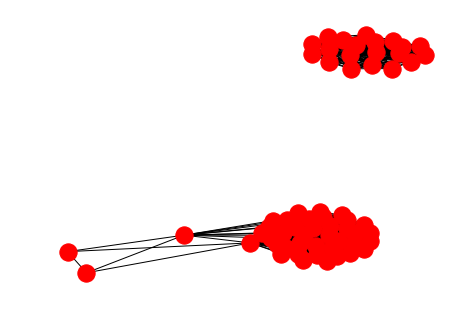

In [73]:
G = nx.from_numpy_matrix(np.array(one_corr_thresh))
pos = nx.spring_layout(G)
nx.draw(G, pos)
plt.show()

In [25]:
adj_mat = np.ndarray((len(channel_data['channel'].unique()), len(channel_data['channel'].unique()), len(channel_data['bin'].unique())))
all_bins = channel_data['bin'].unique()
for k, cur_bin in enumerate(all_bins):
    print('Bin {}'.format(cur_bin))
    cur_channel_data = channel_data[channel_data['bin'] == cur_bin]
    for i, channel_from in enumerate(cur_channel_data['channel'].unique()):
        for j, channel_to in enumerate(cur_channel_data['channel'].unique()):
            adj_mat[i,j, k] = cosine_similarity(cur_channel_data[cur_channel_data['channel'] == channel_from].drop(['bin', 'channel'], axis=1),
                              cur_channel_data[cur_channel_data['channel'] == channel_to].drop(['bin', 'channel'], axis=1))

Bin 0
Bin 1
Bin 2
Bin 3
Bin 4
Bin 5
Bin 6
Bin 7


KeyboardInterrupt: 